<h1>Concrete Strength Regression</h1>

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('Concrete.csv')

In [6]:
df

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [7]:
df.shape

(1030, 9)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [9]:
df.nunique()

cement              278
slag                185
flyash              156
water               195
superplasticizer    111
coarseaggregate     284
fineaggregate       302
age                  14
csMPa               845
dtype: int64

In [10]:
df.isna().sum()

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
flyash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplasticizer,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseaggregate,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineaggregate,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
csMPa,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


<h3>Feature correlation using pearson correlation</h3>

<Axes: >

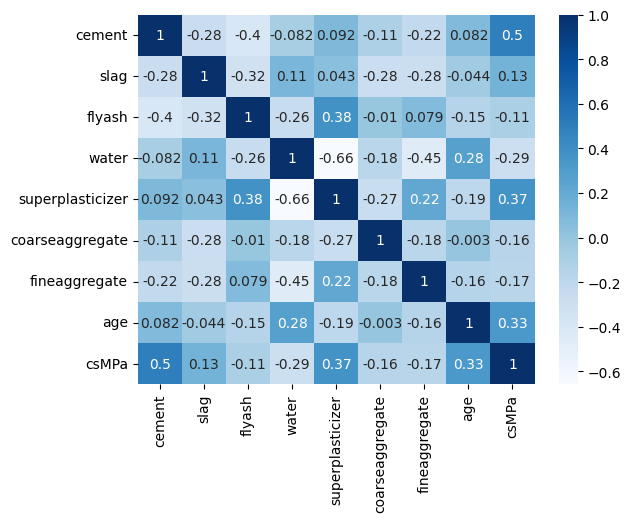

In [12]:
sns.heatmap(df.corr(), annot=True, cmap='Blues')

<Axes: >

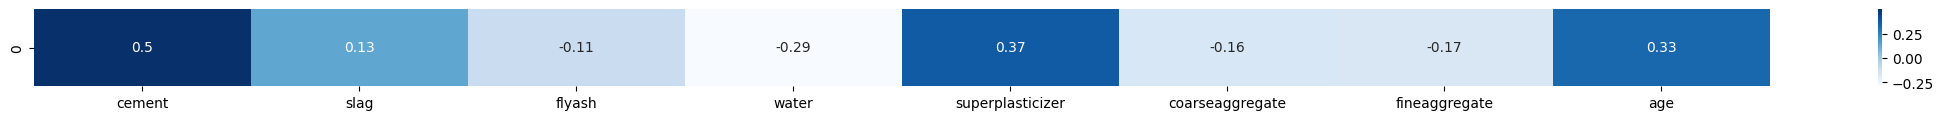

In [13]:
pearson_corr_series = pd.Series(df.corr().iloc[-1,:-1], index=df.columns[:-1])
plt.figure(figsize=(28,1))
sns.heatmap([pearson_corr_series], annot=True, cmap='Blues', xticklabels=pearson_corr_series.index)

<Axes: >

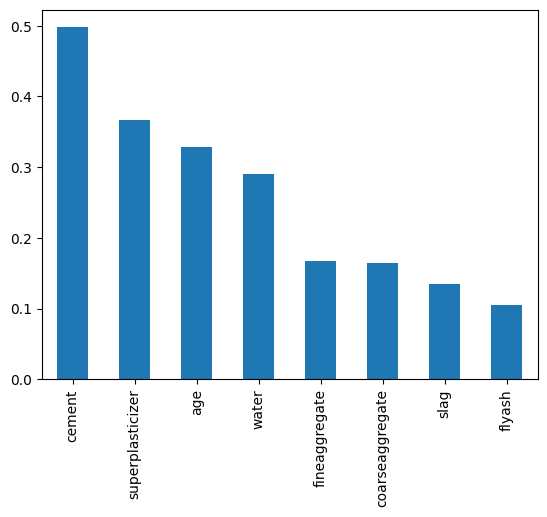

In [14]:
abs(pearson_corr_series).sort_values(ascending=0).plot.bar()

<h3>Top most correlated feature pairs</h3>

In [15]:
df.corr().abs().unstack().sort_values(ascending=0)[9::2]

water             superplasticizer    0.657533
csMPa             cement              0.497832
water             fineaggregate       0.450661
cement            flyash              0.397467
superplasticizer  flyash              0.377503
csMPa             superplasticizer    0.366079
age               csMPa               0.328873
flyash            slag                0.323580
csMPa             water               0.289633
slag              coarseaggregate     0.283999
fineaggregate     slag                0.281603
age               water               0.277618
cement            slag                0.275216
coarseaggregate   superplasticizer    0.265999
flyash            water               0.256984
fineaggregate     cement              0.222718
superplasticizer  fineaggregate       0.222691
                  age                 0.192700
coarseaggregate   water               0.182294
                  fineaggregate       0.178481
fineaggregate     csMPa               0.167241
csMPa        

<h3>Split data into training/test sets</h3>

In [16]:
X = df.drop('csMPa', axis=1).copy()
X

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360
...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28


In [17]:
y = df['csMPa'].copy()

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((824, 8), (206, 8), (824,), (206,))

<h3>Feature importance using mutual information</h3>

In [20]:
from sklearn.feature_selection import mutual_info_regression

<Axes: >

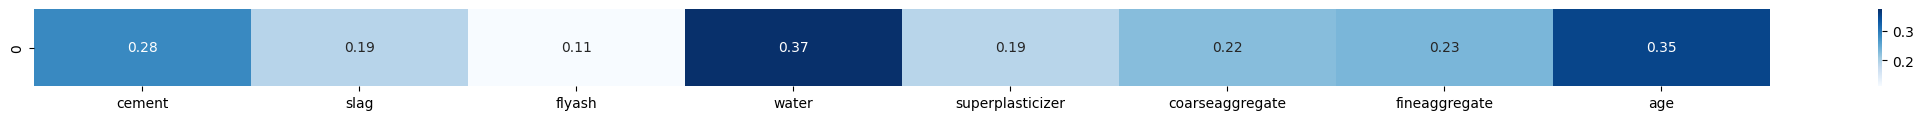

In [21]:
mutual_info_series = pd.Series(mutual_info_regression(X_train, y_train), index = X_train.columns)
plt.figure(figsize=(28,1))
sns.heatmap([mutual_info_series], annot=True, cmap='Blues', xticklabels=mutual_info_series.index)

<Axes: >

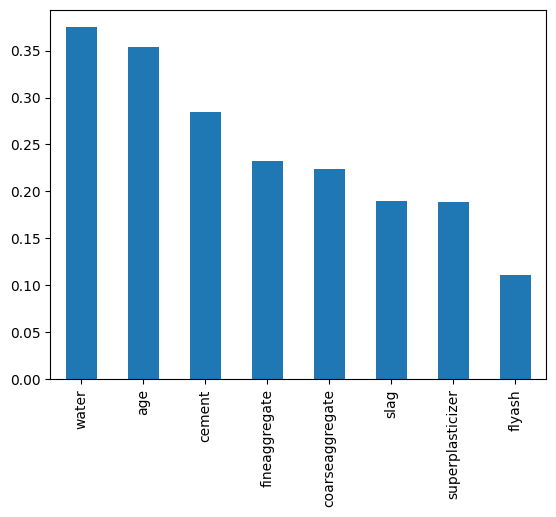

In [22]:
pd.Series(mutual_info_series, index= X_train.columns).sort_values(ascending=0).plot.bar()

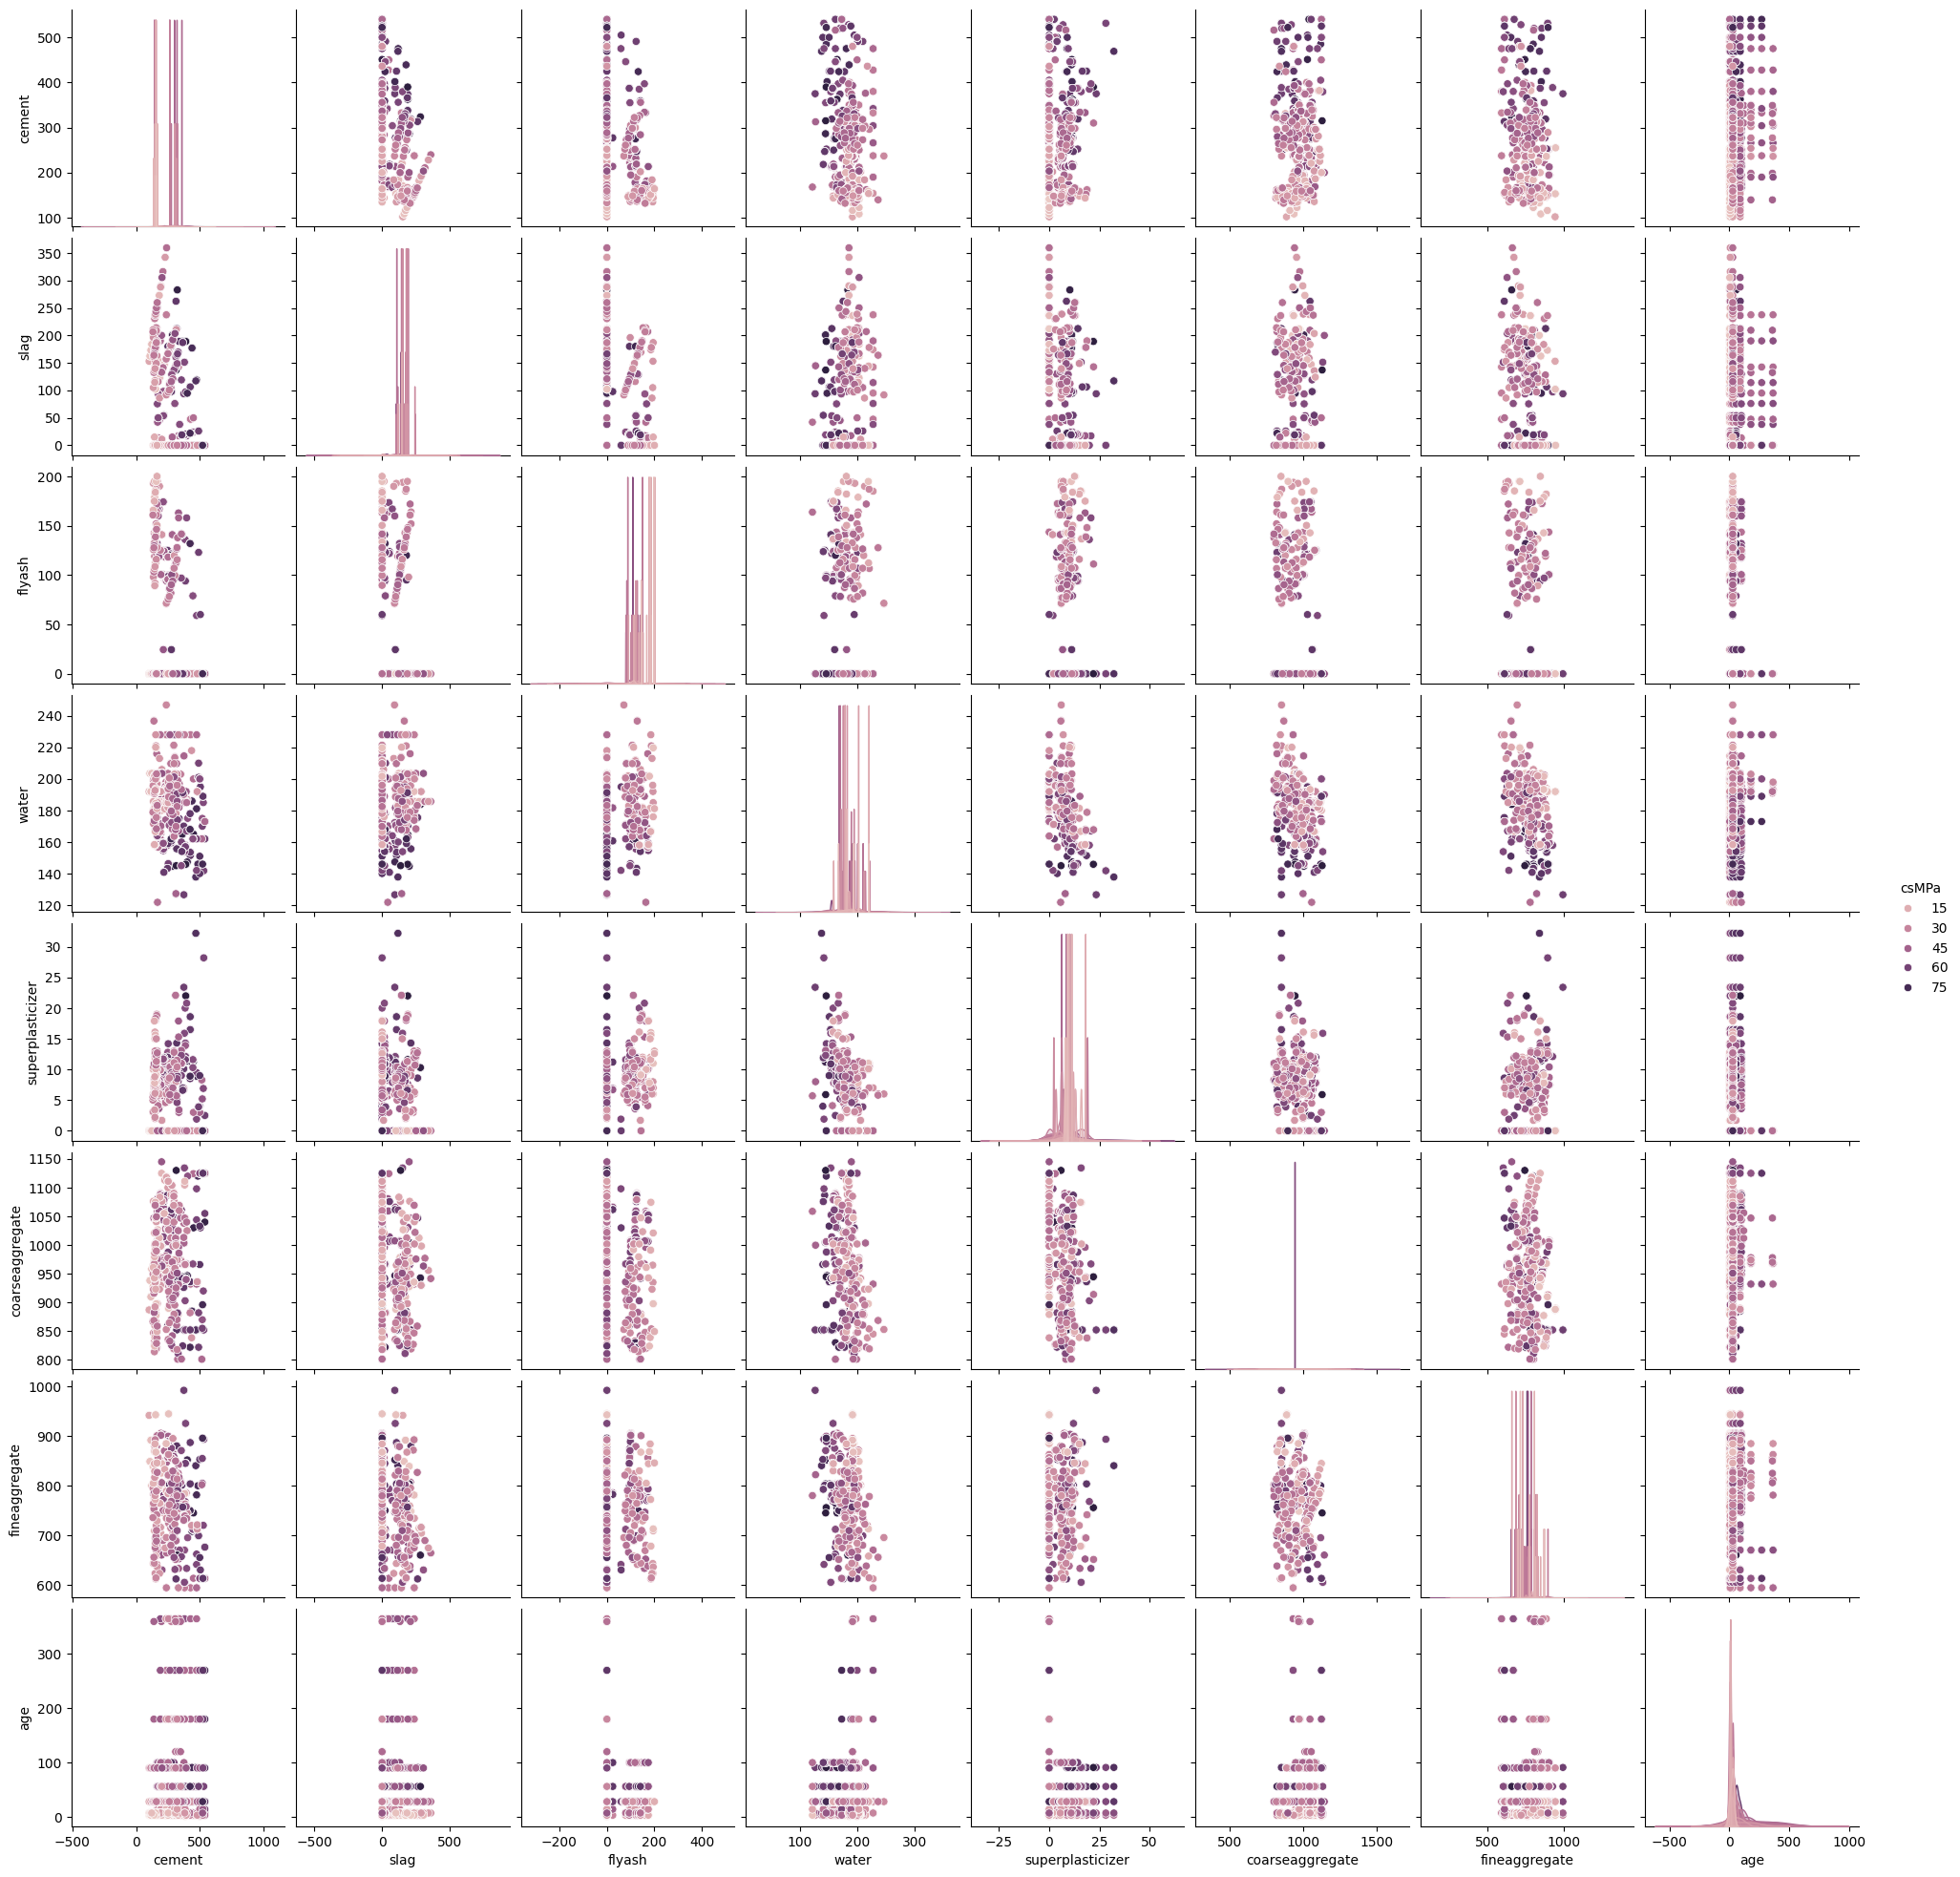

In [23]:
sns.pairplot(data=df, hue='csMPa')

In [24]:
mutual_info_series.sort_values(ascending=False).index

Index(['water', 'age', 'cement', 'fineaggregate', 'coarseaggregate', 'slag',
       'superplasticizer', 'flyash'],
      dtype='object')

<Figure size 1500x1000 with 0 Axes>

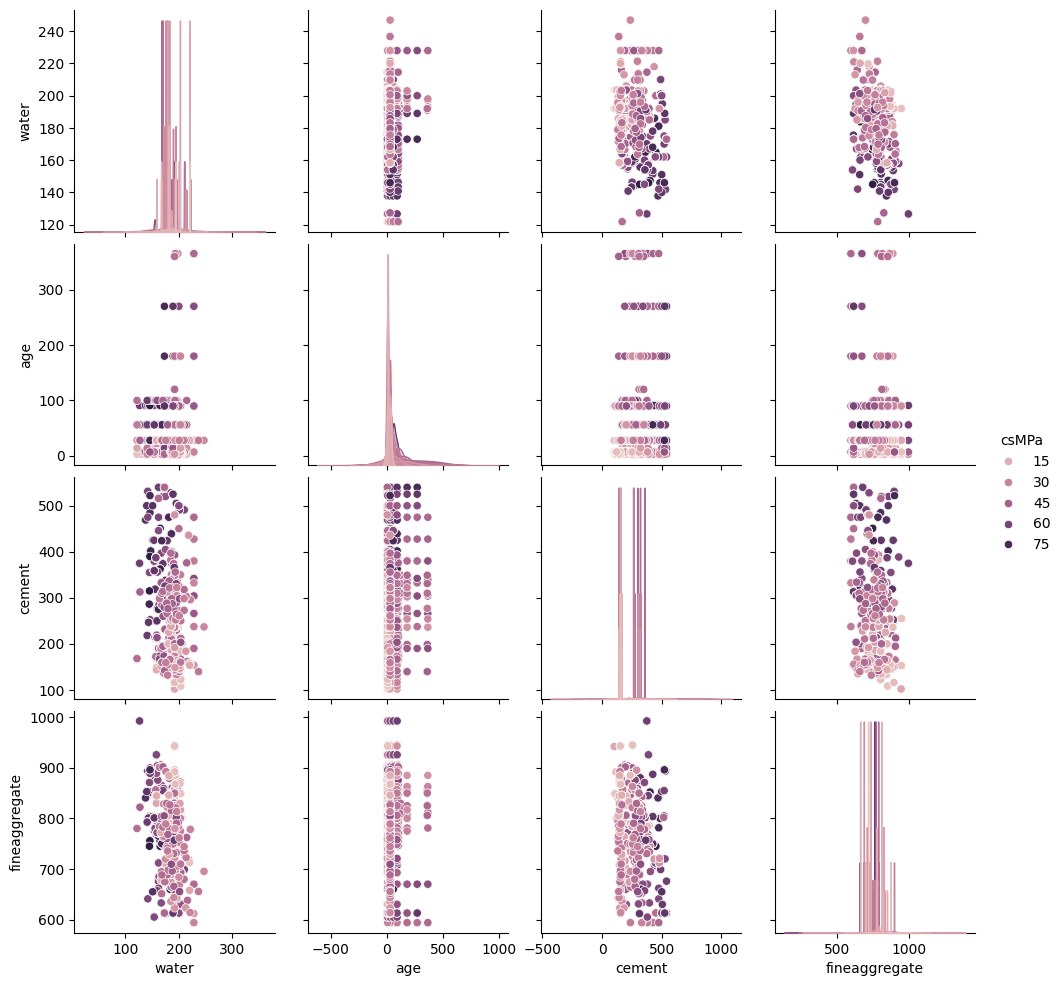

In [25]:
plt.figure(figsize=(15,10))
sns.pairplot(data=df,hue='csMPa', vars=mutual_info_series.sort_values(ascending=0).index[0:4])

<h3>Comparison of Lowest/Highest concrete strength</h3>

In [26]:
comparison_dict = {'5 lowest strength': df.groupby(by='csMPa').mean().iloc[0:5].mean(),
                   '5 greatest strength': df.groupby(by='csMPa').mean().iloc[-5:].mean()}
pd.DataFrame(comparison_dict)

,5 lowest strength,5 greatest strength
cement,125.44,391.70
slag,162.66,159.56
flyash,0.00,0.00
water,198.90,156.52
superplasticizer,0.00,12.54
coarseaggregate,928.64,1000.42
fineaggregate,856.54,718.50
age,3.00,51.80


<h3>Pipeline construction</h3>

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [28]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('standarize',StandardScaler())
])

In [29]:
def prepare_model(algorithm, X_train, y_train):
    
    model = Pipeline(steps=[
        ('preprocessing', num_pipeline),
        ('algorithm', algorithm)
    ])
    model.fit(X_train, y_train)
    return model

<h3>Training algorithms</h3>

In [30]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np

In [31]:
algorithms = [RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), BaggingRegressor(), SVR(),\
             DecisionTreeRegressor(), ExtraTreeRegressor(), LinearRegression(), SGDRegressor(), KNeighborsRegressor(),\
             ]

In [32]:
names = []
times = []
mses = []
maes = []
r2=[]
rsme=[]

for algorithm in algorithms:
    name = type(algorithm).__name__
    names.append(name)
    print(name)
    start_time = time.time()
    model = prepare_model(algorithm, X_train, y_train)
    pred = model.predict(X_test)
    end_time = time.time()
    print(end_time - start_time)
    times.append(end_time - start_time)
    mses.append(mean_squared_error(y_test, pred))
    maes.append(mean_absolute_error(y_test, pred))
    r2.append(r2_score(y_test,pred))
    rsme.append(np.sqrt(mean_squared_error(y_test, pred)))

RandomForestRegressor
0.4221923351287842
AdaBoostRegressor
0.0989983081817627
GradientBoostingRegressor
0.14678120613098145
BaggingRegressor
0.05101203918457031
SVR
0.04976010322570801
DecisionTreeRegressor
0.007999897003173828
ExtraTreeRegressor
0.005000114440917969
LinearRegression
0.016933202743530273
SGDRegressor
0.014880180358886719
KNeighborsRegressor
0.006992816925048828


<h3>Comparing algorithm performance</h3>

In [33]:
results_dict = {'Algorithm': names, 'MSE': mses, 'MAE': maes, 'RSME':rsme, 'Time': times, 'r2 score':r2}
pd.DataFrame(results_dict).sort_values(by='MSE', ascending=1)

,Algorithm,MSE,MAE,RSME,Time,r2 score
0,RandomForestRegressor,20.330208,3.194639,4.508903,0.422192,0.922810
3,BaggingRegressor,22.850091,3.579864,4.780177,0.051012,0.913243
2,GradientBoostingRegressor,24.754077,3.683968,4.975347,0.146781,0.906014
1,AdaBoostRegressor,55.697608,6.219987,7.463083,0.098998,0.788527
5,DecisionTreeRegressor,56.978820,4.824612,7.548432,0.008000,0.783663
6,ExtraTreeRegressor,59.272801,4.822670,7.698883,0.005000,0.774953
9,KNeighborsRegressor,75.134410,6.883417,8.668011,0.006993,0.714730
4,SVR,91.524783,7.581353,9.566859,0.049760,0.652499
8,SGDRegressor,95.316029,7.830786,9.762993,0.014880,0.638104
7,LinearRegression,95.617174,7.864642,9.778403,0.016933,0.636961


<h3>Visualization of true and predicted values on the test set</h3>

Text(0, 0.5, 'Pred')

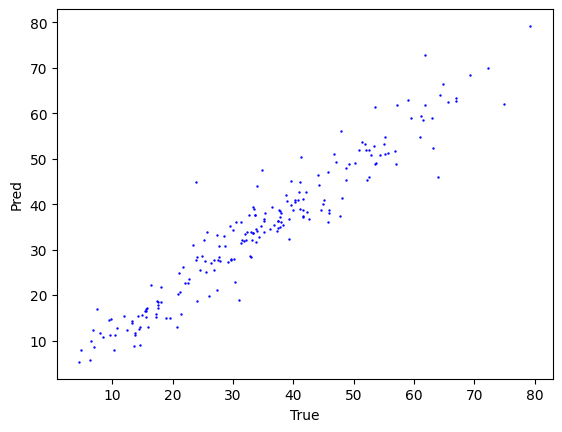

In [34]:
model = prepare_model(RandomForestRegressor(), X_train, y_train)
pred = model.predict(X_test)

plt.scatter(y_test, pred, c='b', s=0.5)
plt.xlabel('True')
plt.ylabel('Pred')

In [35]:
pd.DataFrame({'True': y_test, 'Pred': pred})

,True,Pred
747,26.06,19.71920
718,10.35,7.97950
175,79.30,79.22000
828,74.99,62.14095
713,9.69,11.17820
...,...,...
624,27.53,27.73510
987,33.76,34.44530
424,33.01,28.48540
889,33.72,37.65200


Text(0, 0.5, 'Pred')

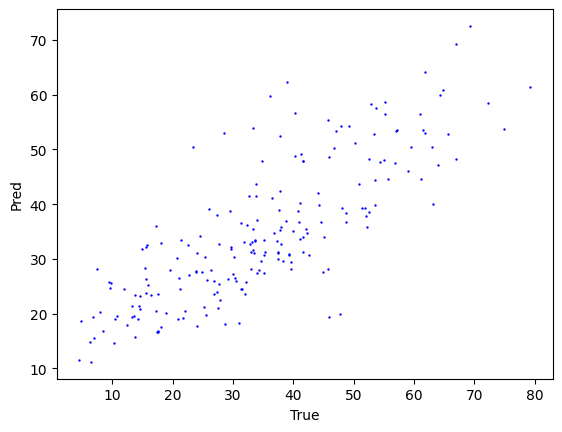

In [36]:
model = prepare_model(LinearRegression(), X_train, y_train)
pred = model.predict(X_test)

plt.scatter(y_test, pred, c='b', s=0.5)
plt.xlabel('True')
plt.ylabel('Pred')

Text(0, 0.5, 'Pred')

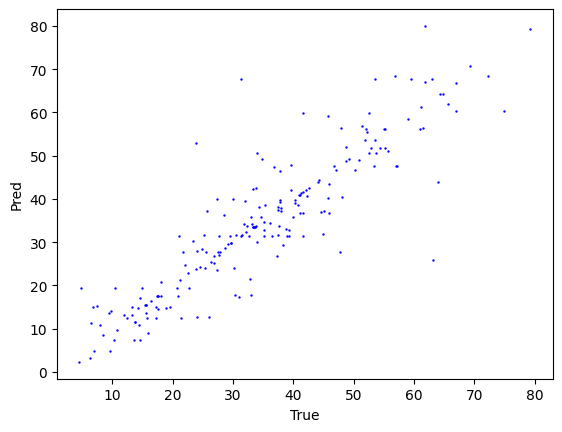

In [37]:
model = prepare_model(DecisionTreeRegressor(), X_train, y_train)
pred = model.predict(X_test)

plt.scatter(y_test, pred, c='b', s=0.5)
plt.xlabel('True')
plt.ylabel('Pred')

Text(0, 0.5, 'Pred')

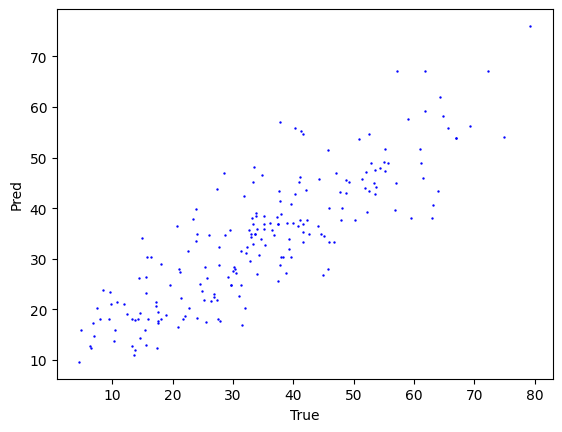

In [38]:
model = prepare_model(KNeighborsRegressor(), X_train, y_train)
pred = model.predict(X_test)

plt.scatter(y_test, pred, c='b', s=0.5)
plt.xlabel('True')
plt.ylabel('Pred')

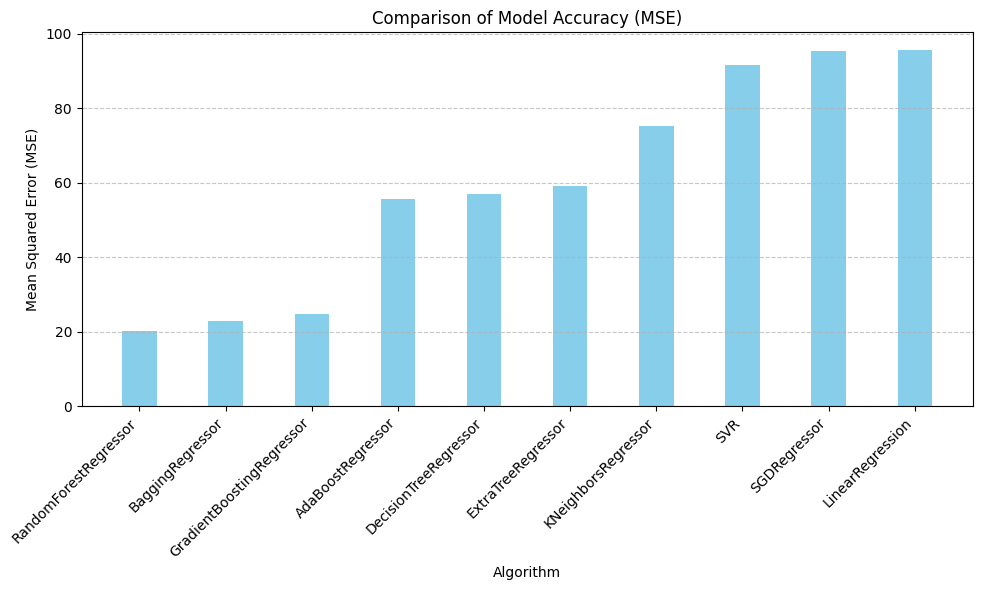

In [49]:
import matplotlib.pyplot as plt

# Data
results_dict = {'Algorithm': names, 'MSE': mses, 'MAE': maes, 'RSME':rsme, 'Time': times, 'r2 score':r2}
results_df = pd.DataFrame(results_dict).sort_values(by='MSE', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(results_df['Algorithm'], results_df['MSE'], color='skyblue', width=0.4)  # Adjust width as needed
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Algorithm')
plt.title('Comparison of Model Accuracy (MSE)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
